# Importing required libraries

In [143]:
import time
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 
sns.set(color_codes=True)

# Read and format data

In [3]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.drop(['Volume_(BTC)', 'Volume_(Currency)'], axis=1, inplace=True)

,Timestamp,Open,High,Low,Close,Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN


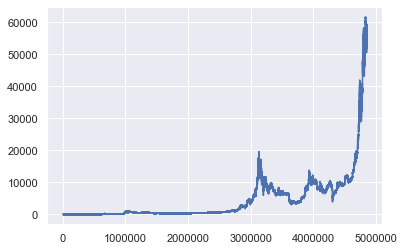

In [108]:
x = df['Timestamp']
y = df['Weighted_Price']

plt.plot(y)
df.head()
#df.tail()

# Important Constants

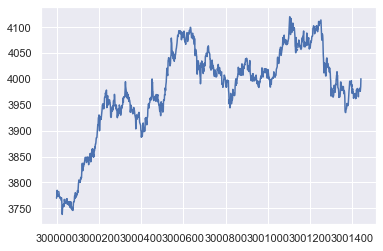

In [178]:
minutes_in_day = 24*60
day_length = minutes_in_day


# example day
lower = 3 * 10**6
upper = lower + minutes_in_day
day = df.loc[lower:upper]
prices = day['Weighted_Price']

plt.plot(prices)

# Helper functions for trading, calculations, visualization

In [179]:
#moving average, most useful in up/down trends over side-to-side

def calc_sd(rank, time_delta, current_index):
    sd = df['Weighted_Price'][current_index-rank*time_delta:current_index].std()
    nan_offset = rank - df['Weighted_Price'][current_index-rank*time_delta:current_index].count()
    return (sd, nan_offset)

def calc_mov_avg(rank, time_delta, current_index):
    average = df['Weighted_Price'][current_index-rank*time_delta:current_index].mean()
    nan_offset = rank - df['Weighted_Price'][current_index-rank*time_delta:current_index].count()
    return (average, nan_offset)

def efficient_mov_avg(prev_avg, rank, time_delta, index, nan_offset):
    old_value = df['Weighted_Price'].iloc[index-time_delta*rank-1]
    new_value = df['Weighted_Price'].iloc[index-1]
    
    old_is_nan = np.isnan(old_value)
    new_is_nan = np.isnan(new_value)
    
    old_divisor = rank-nan_offset # accounting for prev NaN's
    
    if old_is_nan:
        old_value = 0;
        nan_offset-=1
        
    if new_is_nan:
        new_value = 0
        nan_offset+=1
        
    new_divisor = rank - nan_offset # accounting for new NaN's
    
    if new_divisor == 0: # in the event all prev values are NaN
        avg = 0
        
    else:
        avg = (prev_avg * old_divisor - old_value + new_value)/new_divisor
    
    return (avg,nan_offset)

# trade/buy

def get_curr_price(index):
    return df['Weighted_Price'].iloc[index]

def execute_buy(curr_price, cash, coin, prop):
    if cash <= 0:
        return (cash,coin, False)
    coin += cash*prop / curr_price
    cash -= cash*prop
    return (cash,coin, True)

def execute_sell(curr_price, cash, coin, prop):
    if coin <= 0:
        return (cash,coin, False)
    cash += coin*prop * curr_price
    coin -= coin*prop
    return (cash,coin, True)

# analysis

def list_assets(start_cash, cash, coin, end_index, output = True):
    end_value = get_curr_price(end_index)
    total = (end_value * coin + cash)
    delta = ( ((total-start_cash)/start_cash)*100)
    
    if output:
        print("cash: %s" % cash) 
        print("coin: %s " % coin)
        print("total value: %s" % total)
        print("percent change: %s" % delta )
        
    return delta
    
def display_data(overall_wealth, btc, cash, sample_rate, start, end, rank, time_delta):
    scaler = MinMaxScaler()
    overall_wealth = scaler.fit_transform(np.array(overall_wealth).reshape(-1,1))
    overall_btc_price = scaler.fit_transform(np.array(df['Weighted_Price'][start-rank*time_delta:end:sample_rate]).reshape(-1,1))
    btc = scaler.fit_transform(np.array(btc).reshape(-1,1))
    cash = scaler.fit_transform(np.array(cash).reshape(-1,1))
    
    
    plt.plot(df['Timestamp'][start:end:sample_rate],overall_wealth, label='overall wealth')
    plt.plot(df['Timestamp'][start-rank*time_delta:end:sample_rate],overall_btc_price, label='overall btc price')
    #plt.plot(btc, label='btc owned')
    #plt.plot(cash, label='cash on-hand')
    plt.legend(loc='best')
    plt.show()
    
def display_price_over_time_period(figure_index, start, end):
    plt.figure(figure_index)      
    plt.plot(df['Timestamp'][start:end],df['Weighted_Price'][start:end])
    plt.title(f'BTC Price from {start} to {end}')
    plt.xlabel('Time (s)')
    plt.ylabel('Price (USD)')

# Demonstration of efficient vs in-efficient moving average calculations

In [180]:
starting_time = day['Timestamp'].iloc[0] 
moving_avg_rank = 200
starting_index = 3*10**6
time_delta = 1 # each increment/decrement of 1 represents one minute
#time_delta = 60 # data taken at each hour from start
#time_delta = 1440 # data taken at each day from start


# efficient moving average calculation
start_time = time.time()

res = calc_mov_avg(moving_avg_rank, time_delta, starting_index-1*time_delta) #preprocessing
prev_avg = res[0]
nan_offset = res[1]

# n = 1000 # for testing 
for i in range(starting_index, starting_index+len(day)):
    #index = starting_time + i*time_delta
    res = efficient_mov_avg(prev_avg, moving_avg_rank, time_delta, i, nan_offset)
    
    mov_avg = res[0]
    nan_offset = res[1]
    
    #if i == n:
        #print(mov_avg)
    
    prev_avg = mov_avg

    
efficient_time = time.time() - start_time


# inefficient moving average calculation
start_time = time.time()

for i in range(starting_index, starting_index+len(day)):  #for debugging, for i in range(len([i for i in range(n)])):   
    #index = starting_time + i*time_delta
    mov_avg = calc_mov_avg(moving_avg_rank, time_delta, i)[0]
    
    #if i == n:
        #print(mov_avg)

    
inefficient_time = time.time() - start_time


print("efficient: %s seconds" % efficient_time)
print("in-efficient: %s seconds" % inefficient_time)
print("time saved: %s seconds" % (inefficient_time-efficient_time))

efficient: 0.07668018341064453 seconds
in-efficient: 0.5103888511657715 seconds
time saved: 0.43370866775512695 seconds


# Moving Average Calculations Testing

In [181]:
#For verification of accuracy of calculating moving averages

a = np.array([element+.25*element for element in range(20)])



start= 3 * 10**6
end = start + minutes_in_day

prev_avg, nan_offset = calc_mov_avg(50, 60, start-1)
for i in range(start, end):
    
    mov_avg,a = calc_mov_avg(50,60,i)
    eff_mov_avg, nan_offset = efficient_mov_avg(prev_avg, 50, 60,i, nan_offset)
    
    prev_avg = eff_mov_avg
    print(f'{eff_mov_avg}, {mov_avg}')



3669.7998717466617, 3669.7998717466617
3669.8025358700775, 3669.8025358700775
3669.805135460962, 3669.805135460961
3669.8067946368005, 3669.806794636801
3669.812186833378, 3669.812186833378
3669.812509811317, 3669.812509811318
3669.8143582214498, 3669.81435822145
3669.815678358759, 3669.8156783587597
3669.8158764742457, 3669.8158764742457
3669.8163495897998, 3669.8163495898
3669.781208717864, 3669.781208717864
3669.7859182960337, 3669.7859182960337
3669.7928584796614, 3669.7928584796605
3669.7998764549834, 3669.7998764549825
3669.8046797140005, 3669.804679714
3669.8085109010517, 3669.8085109010503
3669.809765081459, 3669.8097650814575
3669.812883388645, 3669.812883388644
3669.811318941391, 3669.8113189413903
3669.808616012069, 3669.8086160120683
3669.806101980543, 3669.8061019805427
3669.8023290991873, 3669.8023290991864
3669.7968831667804, 3669.796883166779
3669.79316985156, 3669.793169851559
3669.756536853951, 3669.75653685395
3669.753533780367, 3669.7535337803656
3669.7458442112925,

3672.8325096898634, 3672.8325096898616
3672.8641818365913, 3672.8641818365895
3672.8979305630073, 3672.897930563006
3672.9277567956624, 3672.927756795661
3672.9544597285885, 3672.954459728587
3672.9809070578867, 3672.9809070578854
3673.010214279657, 3673.010214279655
3673.0386637143806, 3673.038663714379
3673.0644479571747, 3673.064447957173
3673.094393840185, 3673.094393840183
3673.130987915804, 3673.130987915802
3673.167831398815, 3673.167831398813
3673.204412907937, 3673.2044129079354
3673.242736444491, 3673.2427364444907
3673.28528096738, 3673.2852809673786
3673.326583479045, 3673.3265834790445
3673.3663177459152, 3673.3663177459152
3673.4080371461864, 3673.4080371461864
3673.4449966149896, 3673.44499661499
3673.485932613803, 3673.485932613804
3673.524087865278, 3673.524087865279
3673.554385019873, 3673.554385019873
3673.587825554698, 3673.5878255546995
3673.622344760802, 3673.6223447608027
3673.6608205333014, 3673.660820533302
3673.7032014540546, 3673.703201454055
3673.74114911031

3683.052622756213, 3683.0526227562086
3683.115670606552, 3683.1156706065476
3683.169338931722, 3683.1693389317174
3683.2270934755484, 3683.2270934755443
3683.276327549734, 3683.2763275497286
3683.327246242102, 3683.3272462420973
3683.377664082129, 3683.377664082125
3683.427188697291, 3683.4271886972874
3683.4759626805685, 3683.4759626805635
3683.529191012285, 3683.5291910122796
3683.5804668802293, 3683.5804668802234
3683.6319118771426, 3683.631911877137
3683.681253383689, 3683.6812533836837
3683.727504726634, 3683.7275047266276
3683.7762203133366, 3683.77622031333
3683.826176367849, 3683.8261763678415
3683.871145737625, 3683.871145737617
3683.9155984487847, 3683.9155984487775
3683.9650679461392, 3683.965067946132
3684.020206311031, 3684.0202063110237
3684.0719247915936, 3684.0719247915868
3684.12817382599, 3684.1281738259822
3684.188509265508, 3684.1885092655007
3684.247821489253, 3684.247821489244
3684.3105121582153, 3684.3105121582066
3684.3727566801285, 3684.3727566801194
3684.43938

3723.1119566439493, 3723.111956643948
3723.2394796801896, 3723.239479680188
3723.3663751326835, 3723.366375132681
3723.493237595527, 3723.493237595525
3723.623239941065, 3723.6232399410633
3723.7564814649536, 3723.7564814649504
3723.8913247824626, 3723.89132478246
3724.021918210322, 3724.0219182103197
3724.1474628358396, 3724.147462835837
3724.2692376594905, 3724.2692376594878
3724.2956461914187, 3724.2956461914155
3724.4138825377527, 3724.4138825377495
3724.5334216919277, 3724.5334216919246
3724.6510395663, 3724.651039566297
3724.7712588830345, 3724.7712588830314
3724.8972721970194, 3724.8972721970163
3725.024118301398, 3725.0241183013954
3725.1524385635494, 3725.152438563547
3725.2795629745137, 3725.279562974511
3725.4071197433864, 3725.4071197433846
3725.538002213685, 3725.5380022136833
3725.6744760603583, 3725.674476060357
3725.8146738746145, 3725.8146738746136
3725.948796924173, 3725.948796924173
3726.079903896407, 3726.079903896407
3726.208904850616, 3726.208904850616
3726.334713

3761.5524367443704, 3761.5524367443736
3761.659198333712, 3761.6591983337153
3761.764696885613, 3761.7646968856166
3761.8692587899577, 3761.869258789961
3761.973356110901, 3761.9733561109038
3762.0760916192517, 3762.076091619254
3762.1794142195226, 3762.179414219526
3762.284693384899, 3762.2846933849023
3762.3900571038057, 3762.390057103809
3762.4992501306215, 3762.499250130624
3762.6098862984086, 3762.6098862984113
3762.7275707547906, 3762.7275707547933
3762.846384103229, 3762.8463841032317
3762.9649585894817, 3762.964958589484
3763.079318948579, 3763.079318948581
3763.1871142676896, 3763.1871142676914
3763.3005561388027, 3763.3005561388045
3763.4138060631412, 3763.413806063143
3763.5263120236978, 3763.5263120236996
3763.6367848337795, 3763.636784833781
3763.750660255266, 3763.7506602552676
3763.8679952171465, 3763.867995217148
3763.9855584018715, 3763.985558401873
3764.103856974513, 3764.103856974514
3764.2213892020077, 3764.221389202009
3764.3443034009215, 3764.344303400923
3764.467

3796.9429628563635, 3796.942962856361
3797.0449866871536, 3797.0449866871513
3797.1429510661974, 3797.1429510661956
3797.2393145740984, 3797.2393145740966
3797.3020269859717, 3797.3020269859694
3797.366320044939, 3797.3663200449373
3797.467858463441, 3797.46785846344
3797.5726474944813, 3797.57264749448
3797.680940755986, 3797.680940755985
3797.750036968027, 3797.7500369680256
3797.8592940774097, 3797.859294077409
3797.9683231639615, 3797.96832316396
3798.0756658821183, 3798.0756658821174
3798.1788608012243, 3798.178860801223
3798.283801013013, 3798.2838010130117
3798.3896412949234, 3798.389641294922
3798.48817345512, 3798.4881734551186
3798.587750366773, 3798.5877503667716
3798.6881012679582, 3798.688101267958
3798.7887566729714, 3798.78875667297
3798.888871638249, 3798.8888716382476
3798.9883934365216, 3798.9883934365203
3799.0913187925853, 3799.091318792585
3799.1940250313723, 3799.194025031372
3799.3015026764947, 3799.301502676494
3799.4052568947536, 3799.4052568947523
3799.5064211

# Moving Average Trading Simulation

cash: 0.0
coin: 0.12360642406212789 
total value: 1031.4679859146431
percent change: 3.146798591464312


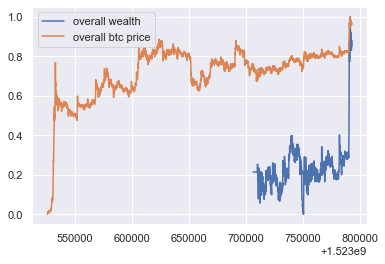

In [195]:
#buy when above, sell when below
#golden cross (50 day crosses above 200 day, bearish to bullish) vs death cross 

start = int(3.3 * 10**6 + 0*len(day))
end = start + 1*len(day)
rank = 50
time_delta = 60 #1, 60, 1440 for minutes, hours, days, respectively

cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #preprocessing
prev_price = get_curr_price(start-1)

sample_rate = 1
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len

buy_proportion = 1
sell_proportion = 1
arr_index = 0
for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if curr_price > mov_avg and prev_price < mov_avg: #handles NaN
        buy+=1
        cash,coin,success = execute_buy(curr_price, cash, coin, buy_proportion)

    elif curr_price < mov_avg and prev_price > mov_avg: #handles NaN
        sell+=1
        cash,coin,success = execute_sell(curr_price, cash, coin, sell_proportion)

    if (i-start) % sample_rate == 0:
        btc_value_dollars[arr_index] = coin * curr_price
        cash_value_dollars[arr_index] = cash
        overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
        arr_index+=1
        
    prev_price = curr_price
    prev_avg = mov_avg 
        
list_assets(starting_wealth, cash, coin, end)
display_data(overall_wealth, btc_value_dollars, cash_value_dollars, sample_rate, start, end, rank, time_delta)

# Percentage Trigger Trading Simulation

trade prop = 0.9: (trigger = 0.03, profit = -3.7933%)
trade prop = 0.9: (trigger = 0.04, profit = 4.4149%)
trade prop = 0.9: (trigger = 0.05, profit = 10.6861%)
trade prop = 0.9: (trigger = 0.06, profit = 2.7248%)
trade prop = 0.9: (trigger = 0.07, profit = 4.8601%)
trade prop = 0.9: (trigger = 0.08, profit = 17.1577%)
 
trade prop = 1.0: (trigger = 0.03, profit = -4.8242%)
trade prop = 1.0: (trigger = 0.04, profit = 3.7094%)
trade prop = 1.0: (trigger = 0.05, profit = 10.9196%)
trade prop = 1.0: (trigger = 0.06, profit = 0.5741%)
trade prop = 1.0: (trigger = 0.07, profit = 2.4618%)
trade prop = 1.0: (trigger = 0.08, profit = 21.0019%)
 


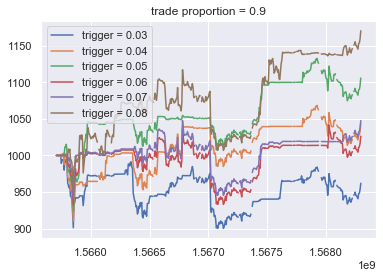

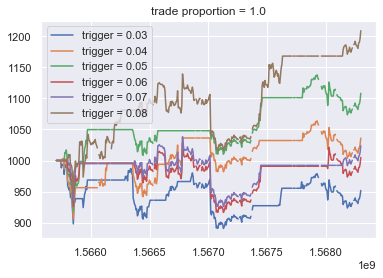

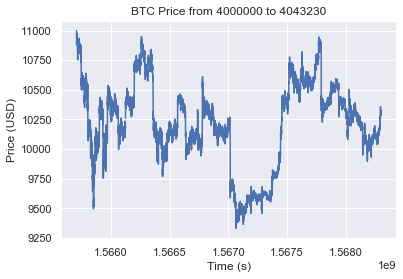

In [199]:
#simple buying and selling when percentage threshold is met

#print(f'{cash},{coin}') # for debugging
#print(f'{curr_price} buy')

def calc_thresholds(index, trigger_threshold):
    reference_price = get_curr_price(index)
    sell = (1 + trigger_threshold) * reference_price
    buy = (1 - trigger_threshold) * reference_price
    return (reference_price, sell, buy)
    
start = int(4 * 10**6 + 0*len(day)) # TOGGLE for start of time period
end = start + 30*len(day) # TOGGLE for end of time period

#end = 4857376 # across all data
#start = end - len(day) # across all data

sample_rate = 100
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len


buy_proportions = [el/10 for el in range(9,11)] # TOGGLE this range to allow for trading w/ different trading proportions

trigger_thresholds = [el/100 for el in range(3,9)] # TOGGLE this range to allow for different percentage triggers
deltas = [float] * len(trigger_thresholds) # holds percentage changes of portfolio value
deltas_index = 0
figure = 0

for buy_prop in buy_proportions:
    
    deltas_index = 0
    plt.figure(figure)
    plt.title(f'trade proportion = {buy_prop}')
    
    for trigger_threshold in trigger_thresholds:
        
        cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
        starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
        
        reference_price, sell_threshold, buy_threshold = calc_thresholds(start-1, trigger_threshold)
        #print(f'ref price: {reference_price}')
        for i in range(start, end):
            
            curr_price = get_curr_price(i)

            if curr_price >= sell_threshold: #handles NaN
                buy+=1
                cash, coin, succcess = execute_sell(curr_price, cash, coin, buy_prop)
                if True:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            elif curr_price <= buy_threshold: #handles NaN
                sell+=1
                cash, coin, success = execute_buy(curr_price, cash, coin, buy_prop)
                if True:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            if (i-start) % sample_rate == 0:
                btc_value_dollars[arr_index] = coin * curr_price
                cash_value_dollars[arr_index] = cash
                overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
                arr_index+=1
                
        plt.plot(df['Timestamp'][start:end:sample_rate],overall_wealth, label=f'trigger = {trigger_threshold}') # uncomment to graph different trigger thresholds
        deltas[deltas_index] = list_assets(starting_wealth, cash, coin, end, output=False)
        deltas_index+=1

    plt.legend(loc='best')
   
    for i in range(len(trigger_thresholds)):   
        print(f'trade prop = {buy_prop}: (trigger = {trigger_thresholds[i]}, profit = {round(deltas[i],4)}%)')
    print(' ')
    figure+=1
    
display_price_over_time_period(figure, start, end)

# Visualization of Bollinger Bands w/ Trading Simulation

cash: 1131.8305375026873
coin: 0.0 
total value: 1131.8305375026873
percent change: 13.183053750268733


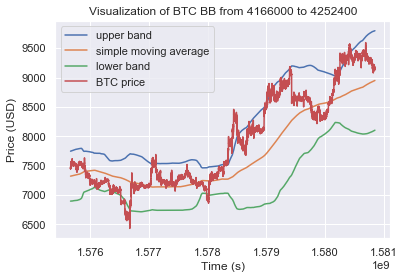

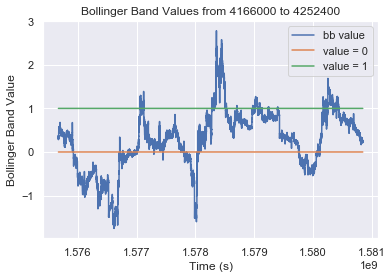

In [232]:
#bb value < 0: buying position 
#bb value > 1: selling position

sd_map = {
    10:1.5,
    14:2,
    20:2,
    50:2.5,
}

start = int(4.166 * 10**6 + 0*len(day))
end = start + int(60*minutes_in_day)
rank = 14
time_delta = 1440 # TOGGLE 1, 60, 1440 for minutes, hours, days, respectively
time_interval = end-start

cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #preprocessing
prev_price = get_curr_price(start-1)

sample_rate = 1
trade_prop = 1

arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

upper_band = [float] * arr_len
moving_avg = [float] * arr_len
lower_band = [float] * arr_len
bb_values = [float] * arr_len


arr_index = 0

for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if (i-start) % sample_rate == 0:
        
        sd = calc_sd(rank, time_delta, i)[0]
        upper_band[arr_index] = mov_avg + (sd * sd_map[rank])
        moving_avg[arr_index] = mov_avg
        lower_band[arr_index] = mov_avg - (sd * sd_map[rank])
        bb_values[arr_index] = (curr_price - mov_avg) / (sd * sd_map[rank])
        
        if curr_price >= upper_band[arr_index] and prev_price < upper_band[arr_index]: #sell on upper band
            cash, coin, succcess = execute_sell(curr_price, cash, coin, trade_prop)
            #break
        elif curr_price <= lower_band[arr_index] and prev_price > lower_band[arr_index]: #buy on lower band
            cash, coin, succcess = execute_buy(curr_price, cash, coin, trade_prop)
    
        arr_index+=1
        
    prev_avg = mov_avg
    prev_price = curr_price
    
list_assets(starting_wealth, cash, coin, end)    
    
time_space = df['Timestamp'][start:end:sample_rate]

plt.figure(0)
plt.plot(time_space, upper_band, label='upper band')
plt.plot(time_space, moving_avg, label='simple moving average')
plt.plot(time_space, lower_band, label='lower band')
plt.plot(time_space, df['Weighted_Price'][start:end:sample_rate], label='BTC price')
plt.title(f'Visualization of BTC BB from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.figure(1)
plt.plot(time_space, bb_values, label='bb value')
plt.plot(time_space, [0] * arr_len, label='value = 0')
plt.plot(time_space, [1] * arr_len, label='value = 1')
plt.title(f'Bollinger Band Values from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Bollinger Band Value')
plt.legend(loc='best')